In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import numpy as np

print(tf.__version__)

2022-11-14 20:07:52.175620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 20:07:52.368807: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jazhiel/Root/root/lib
2022-11-14 20:07:52.368829: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-14 20:07:52.407587: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-14 20:07:52.94

2.10.0


In [2]:
image_dir = "/home/jazhiel/ML_Notebooks/YT_ensayo/Figuras_ANN_Isidro/New_Datasets/Projections_axis_off/"
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
images[:2]

['/home/jazhiel/ML_Notebooks/YT_ensayo/Figuras_ANN_Isidro/New_Datasets/Projections_axis_off/D37_x_axis_off_Projection_x_density_density.png',
 '/home/jazhiel/ML_Notebooks/YT_ensayo/Figuras_ANN_Isidro/New_Datasets/Projections_axis_off/D27_z_axis_off_Projection_z_density_density.png']

In [3]:
# preprocess
image_size = 64

## tf.io is an api for image processing



#TensorFlow I/O is a collection of file systems and file formats that are not available in TensorFlow's built-in
#support.

#It provides useful extra Dataset, streaming, and file system extensions, and is maintained by TensorFlow SIG-IO.

#### add a tf.crop in order to resize and add the 3 color channels


def preprocess(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0
    image = tf.image.random_crop(image,  size=[64,64,3])
    image = tf.reshape(image, shape = (image_size, image_size, 3))
    return image

In [4]:
batch_size = 2

training_dataset = tf.data.Dataset.from_tensor_slices((images))
training_dataset = training_dataset.map(preprocess)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

2022-11-14 20:15:33.010039: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jazhiel/Root/root/lib
2022-11-14 20:15:33.010123: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-14 20:15:33.010201: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Nitro-N5-Jazhiel): /proc/driver/nvidia/version does not exist
2022-11-14 20:15:33.024644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:


len(training_dataset)



39

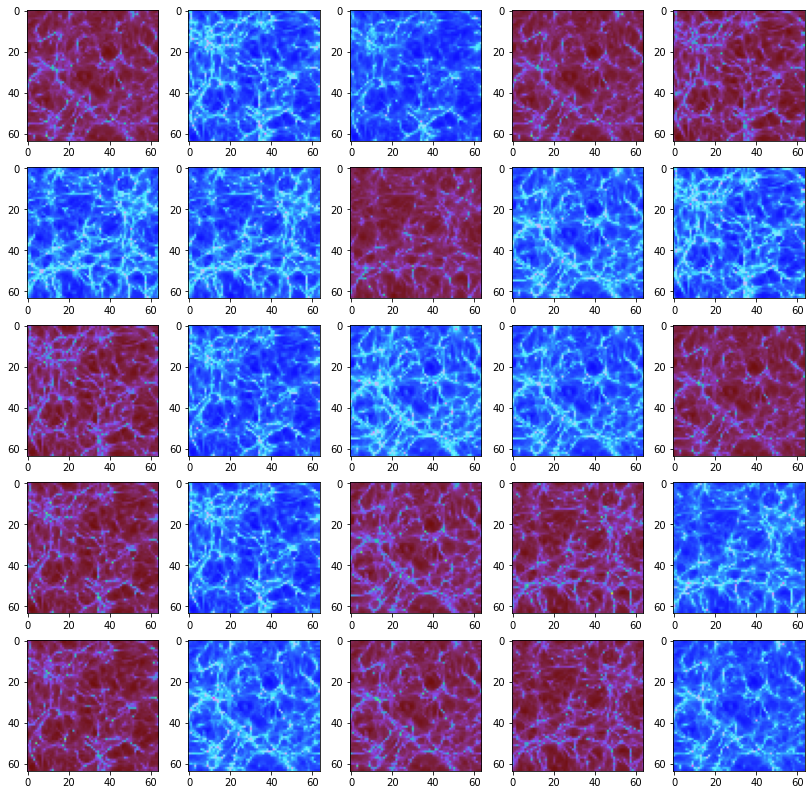

In [6]:
# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])
        idx+=1

In [7]:


# build the model

latent_dim = 512



In [8]:


from keras.models import Sequential, Model

from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
#from keras.layers.advanced_activations import LeakyReLU

from keras.layers.activation import LeakyReLU

from keras.activations import selu
from keras.layers import Multiply, Add
from keras.optimizers import Adam

from keras import backend as K



In [9]:


K.clear_session()




In [10]:
### Define the model



encoder_input = Input(shape = (64,64,3)) ### 3 channels one for each color


###convolutional layer adds convolution filters matrices to images
#### Stride is a parameter of the neural network's filter that modifies the amount of movement
###over the image or video.  For example, if a neural network's stride is set to 1,
#the filter will move one pixel, or unit,  at a time
#the kernel size refers to how mani pixels will have the convolutional filter kernel, in this case
### kernel size = 5means a 25 total pixel amount filter is applied

### Padding refers to  it refers to the amount of pixels added to an image 
#when it is being processed by the kernel of a CNN.
#For example, if the padding in a CNN is set to zero,
#then every pixel value that is added will be of value zero. 
#If, however, the zero padding is set to 1, 
##there will be a one pixel border added to the image with a pixel value of zero.


## batch normalization  normalization of the layers' inputs by re-centering and re-scaling.
### prevents some layers exploding (gradient explosion)

x = Conv2D(32, kernel_size=5, activation = LeakyReLU(0.02), strides = 1, padding = 'same')(encoder_input)
x = BatchNormalization()(x)

filter_size = [64,128,256,512]
for i in filter_size:
    x = Conv2D(i, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)

# sampling layer
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

epsilon = K.random_normal(shape = (tf.shape(mu)[0], tf.shape(mu)[1]))
sigma = tf.exp(0.5 * log_var)

z_eps = Multiply()([sigma, epsilon])
z = Add()([mu, z_eps])

encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
encoder.summary()



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   2432        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   51264       ['batch_normalization[0][0]

2022-11-14 20:15:53.799331: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 33554432 exceeds 10% of free system memory.
2022-11-14 20:15:53.812552: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 33554432 exceeds 10% of free system memory.
2022-11-14 20:15:53.820577: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 33554432 exceeds 10% of free system memory.


 dense (Dense)                  (None, 1024)         8389632     ['flatten[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 1024)        4096        ['dense[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_1 (Dense)                (None, 512)          524800      ['batch_normalization_5[0][0]']  
                                                                                                  
 dense_2 (Dense)                (None, 512)          524800      ['batch_normalization_5[0][0]']  
                                                                                                  
 tf.compat.v1.shape (TFOpLambda  (2,)                0           ['dense_1[0][0]']                
 )        

In [11]:
# build the decoder

### the decoder essentially has to deconvolute all convolutional layers
### that's why we see a lot of selu activation functions as well as transposed convolution layers

decoder = Sequential()
decoder.add(Dense(1024, activation = selu, input_shape = (latent_dim, )))
decoder.add(BatchNormalization())

decoder.add(Dense(8192, activation = selu))
decoder.add(Reshape((4,4,512)))

decoder.add(Conv2DTranspose(256, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(3, (5,5), activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())

decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_6 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 8192)              8396800   
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        3277056   
 nspose)                                                         
                                                                 
 batch_normalization_7 (Batc  (None, 8, 8, 256)        1

2022-11-14 20:15:55.304204: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 33554432 exceeds 10% of free system memory.
2022-11-14 20:15:55.316364: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 33554432 exceeds 10% of free system memory.


In [12]:
### Put Kullback Leiber divergence definition somewhere

# make loss function 
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, log_var)



In [13]:


# conbine encoder and decoder
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mu, log_var)
model.add_loss(loss)
model.summary()



Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 512),        13802688    ['input_1[0][0]']                
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 3)    13283023    ['encoder[0][2]']                
                                                                                                

In [14]:


# make a function to save images while learning
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image)
            axes[row, column].axis("off")
            idx+=1
    output_path = "/home/jazhiel/ML_Notebooks/YT_ensayo/Figuras_ANN_Isidro/New_Datasets/output_vae/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()



In [ ]:
# train vae

from keras.optimizers import Adam

random_vector = tf.random.normal(shape = (25, latent_dim,))
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []

optimizer = Adam(0.0001, 0.5)
epochs = 100

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])
            
            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())
            
            kl = sum(model.losses)
            kl_losses.append(kl.numpy())
            
            train_loss = 0.01 * kl + mse_loss
            
            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            if step % 10 == 0:
                save_images(decoder, epoch, step, random_vector)
            print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))


1/1 [==============================] - 1s 629ms/step
Epoch:  1
1/1 [==============================] - 0s 141ms/step
Epoch: 1 - Step: 0 - MSE loss: 0.05385823 - KL loss: 0.00033751834
Epoch: 1 - Step: 1 - MSE loss: 0.055241186 - KL loss: 0.00031188224
Epoch: 1 - Step: 2 - MSE loss: 0.09790701 - KL loss: 0.00038629363
Epoch: 1 - Step: 3 - MSE loss: 0.0963974 - KL loss: 0.00034492358
Epoch: 1 - Step: 4 - MSE loss: 0.05527404 - KL loss: 0.00017631176
Epoch: 1 - Step: 5 - MSE loss: 0.053293347 - KL loss: 0.00014425887
Epoch: 1 - Step: 6 - MSE loss: 0.09722584 - KL loss: 0.00021327633
Epoch: 1 - Step: 7 - MSE loss: 0.052557826 - KL loss: 0.0001176536
Epoch: 1 - Step: 8 - MSE loss: 0.13616757 - KL loss: 0.0002843959
Epoch: 1 - Step: 9 - MSE loss: 0.13672553 - KL loss: 0.0002355057
1/1 [==============================] - 0s 246ms/step
Epoch: 1 - Step: 10 - MSE loss: 0.09660401 - KL loss: 0.0001293208
Epoch: 1 - Step: 11 - MSE loss: 0.13787527 - KL loss: 0.00017370161
Epoch: 1 - Step: 12 - MSE l

In [ ]:
# visualize output

import cv2
output_dir = "/home/jazhiel/ML_Notebooks/output/"
files = os.listdir(output_dir)

for file in files:
    image = cv2.imread(output_dir + file)
    cv2.imshow("Output", image)
    if cv2.waitKey(1) and 0xFF == ord('q'):
        break